In [176]:
import json

scientific_titles = []
with open('json/related-articles_pro-science.json', 'r') as storage:
    info = json.loads(storage.read())
    for article in info:
        scientific_titles.append(article[0])

conspiracy_titles = [] 
with open('json/related-articles_conspiracy.json', 'r') as storage:
    info = json.loads(storage.read())
    for article in info:
        conspiracy_titles.append(article[0])

In [177]:
from nltk import word_tokenize
from nltk.corpus import stopwords
from dateutil.parser import parse
from nltk.stem import WordNetLemmatizer
from article_finder import ArticleFinder

import string
import nltk

class BagOfWords:
    def __init__(self, tokenized_paragraph: list, is_positive: bool):
        self.sentences = tokenized_paragraph
        self.is_positive = is_positive

    def tokenize(self):
        self.words = []
        for sentence in self.sentences:
            for word in word_tokenize(sentence):
                self.words.append(word)

    def to_lower_case(self):
        for i in range(len(self.words)):
            self.words[i] = self.words[i].lower()

    def clean_data(self):
        noise = ['...', "n't"]
        def is_time_or_date(word):  
            try:
                parsed = parse(word)
                return True
            except:
                return False

        def is_link(word):
            for suffix in ArticleFinder.suffixes:
                if suffix in word:
                    return True
            return False

        # rn = set()

        for i in range(len(self.words)-1, -1, -1):
            if len(self.words[i]) <= 2 or self.words[i].isnumeric() or is_time_or_date(self.words[i]) or self.words[i] in noise or is_link(self.words[i]):
                self.words.pop(i)
                continue
        
            # shave punctation off of beginnings and from the end
            start_ind, end_ind = -1, -1
            for j in range(len(self.words[i])):
                if self.words[i][j] in string.ascii_lowercase or self.words[i][j].isnumeric():
                    start_ind = j
                    break
            for j in range(len(self.words[i])-1, -1, -1):
                if self.words[i][j] in string.ascii_lowercase or self.words[i][j].isnumeric():
                    end_ind = j
                    break

            if (start_ind == 0 and end_ind == len(self.words[i])-1) or start_ind >= end_ind:
                continue

            self.words[i] = self.words[i][start_ind:end_ind+1]
            # rn.add((self.words[i], self.words[i][start_ind:end_ind+1]))

    def remove_stop_words(self):
        for i in range(len(self.words)-1, -1, -1):
            if self.words[i] in stopwords.words('english'):
                self.words.pop(i)  

    def normalize_words(self):
        def get_part_of_speech(provided_word):
            _, part_of_speech = nltk.pos_tag([provided_word])[0]
            if 'NN' in part_of_speech:
                return 'n'
            if 'VB' in part_of_speech:
                return 'v'
            if 'JJ' in part_of_speech:
                return 'a'
            if 'RB' in part_of_speech:
                return 'r'
            return 'n'

        lemmatizer = WordNetLemmatizer()
        for i in range(len(self.words)):
            self.words[i] = lemmatizer.lemmatize(self.words[i], get_part_of_speech(self.words[i]))

    def create_frequency_chart(self):
        self.freqChart = dict()

        for word in self.words:
            if word not in self.freqChart:
                self.freqChart[word] = 1
            else:
                self.freqChart[word] += 1

        # sorting in ascending order by value
        self.freqChart = {word: self.freqChart[word] for word in sorted(self.freqChart, key=self.freqChart.get, reverse=True)}


In [178]:
a = BagOfWords(scientific_titles, True)

a.tokenize()
a.to_lower_case()
a.clean_data()
a.remove_stop_words()
a.normalize_words() # todo: improve part of speech performance
a.create_frequency_chart()


# print(a.freqChart)

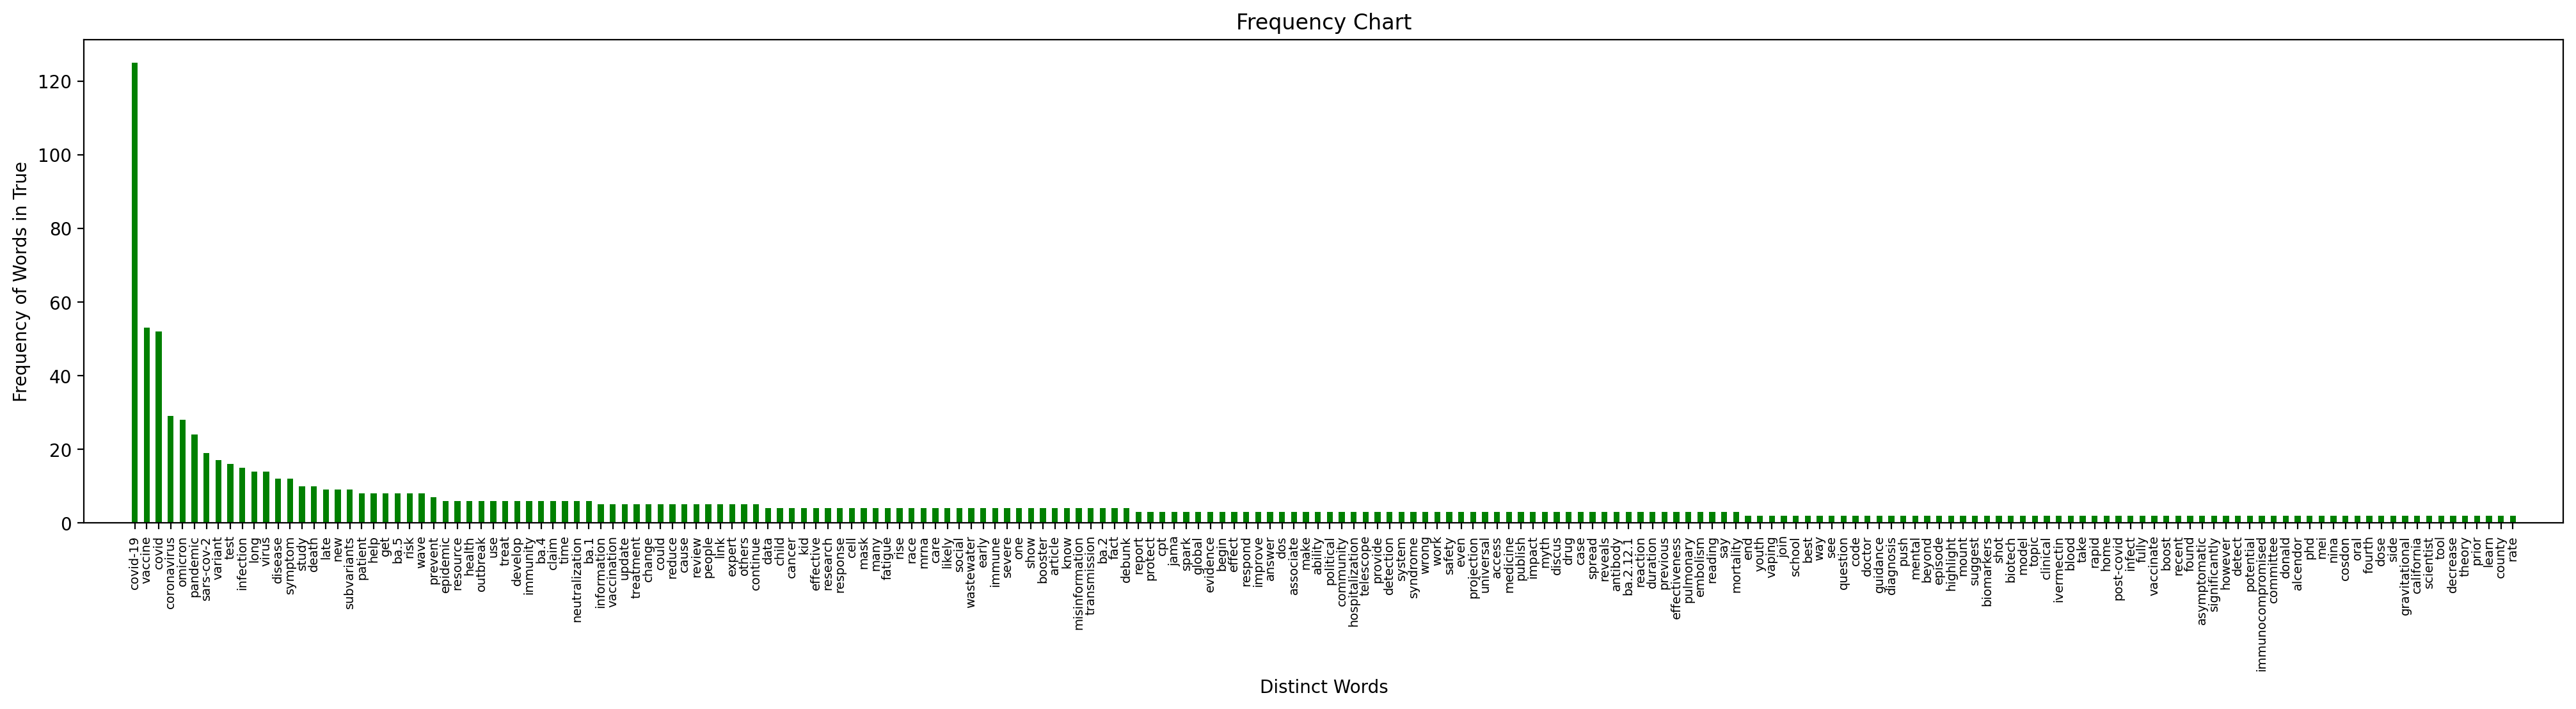

In [243]:
import matplotlib.pyplot as plt

words = list(a.freqChart.keys())[:200]
frequencies = list(a.freqChart.values())[:200]

plt.figure(figsize=(25, 5), dpi=200)
plt.margins(x=0.02, tight=True)
plt.bar(words, frequencies, color ='green', width = 0.5)

# setting title and labels
plt.xlabel("Distinct Words")
plt.xticks(rotation = 90, fontsize=7)

plt.ylabel(f"Frequency of Words in {a.is_positive}")
plt.title("Frequency Chart")

# loading the plot
plt.show()
